In [ ]:
import geopandas as gpd
import momepy
import networkx as nx
from shapely.geometry import LineString, MultiLineString, Point, LineString
from itertools import combinations
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

## Lecture du réseau routier

In [ ]:
file_reseau = "data/reseau route eure.shx"
file_clients = "data/clients.shx"
file_arrivee = "data/arrivée et retour.shx"

# Lire le shapefile avec GeoPandas
gdf_reseau = gpd.read_file(file_reseau)


# Nettoyer le GeoDataFrame
gdf_reseau = gdf_reseau.explode(index_parts=False).reset_index(drop=True)  # sépare les MultiLineString
gdf_reseau = gdf_reseau[gdf_reseau.geometry.type == 'LineString']  # garde uniquement les LineString valides
gdf_reseau = gdf_reseau[~gdf_reseau.geometry.is_empty & gdf_reseau.geometry.notnull()]  # retire les géométries vides

# On converti le geopandas du réseau routier en réseau networkx

g_reseau = momepy.gdf_to_nx(gdf_reseau, approach='primal')

# On vérifie que le réseau est topologiquement connecté (1 seule composante)
components = list(nx.connected_components(g_reseau.to_undirected()))
print(f"Nombre de composantes : {len(components)}")

# fichier clients
gdf_clients = gpd.read_file(file_clients)


# arrivée et retour de la livraison
gdf_liv = gpd.read_file(file_arrivee)

Nombre de composantes : 1


# Visualisation du réseau et des clients

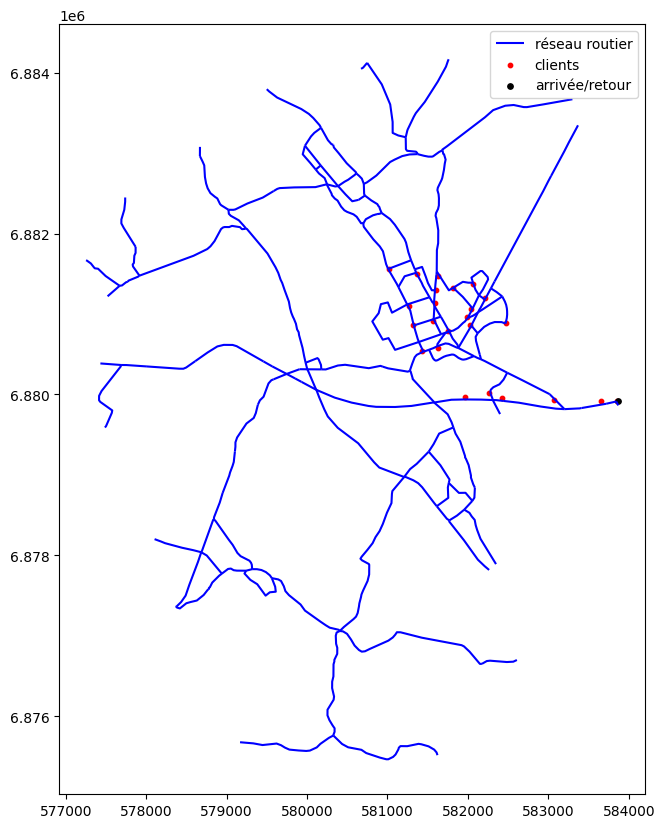

In [ ]:
if gdf_reseau.crs != gdf_clients.crs:
    gdf2 = gdf_clients.to_crs(gdf_reseau.crs)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf_reseau.plot(ax=ax, color='blue', edgecolor='black', legend=True, label='réseau routier')

gdf_clients.plot(ax=ax, color='red', markersize=10, label='clients')
gdf_liv.plot(ax=ax, color='black', markersize=15, label='arrivée/retour')
ax.set_title("")
ax.legend(loc='upper right') 
plt.show()

## Recherche des points du réseau les plus près des points de livraison

Les coordonnées des points de livraison ne coincident pas exactemment avec les coordonnées des noeuds du graphe routier. Je crée une fonction qui va permettre d'attribuer un "type" à chaque noeuds du graphe routier. le noeud le plus proche d'un client -> "type" = "nom du client"; le noeud le plus proche du départ/arrivéé -> "type" = "depart". Les autres noeuds "type"="interieur"

In [106]:
def type_point_reseau(g_reseau,nodes_livr):

    import numpy as np
    nodes_list = list(g_reseau.nodes) # liste des noeuds du réseau
    dico_attribut_nodes = dict() # dictionnaire dans lequel on va définir l'attribut "type"
    list_nom_clients = list()
    coordinates = dict()

    for idx, row in nodes_livr.iterrows(): # on boucle sur tous les points de livraison
        x_liv = row['x']
        y_liv = row['y']
                
        nearest_node = nodes_list[0] # On initialise le noeud le plus proche comme étant le 1er noeud du réseau routier
        X = nearest_node[0]
        Y = nearest_node[1]
        list_nom_clients.append(row['client'])


        d_nearest = np.sqrt((x_liv-X)**2 + (y_liv-Y)**2) # on calcul la distance initale entre le points de livraison et le point du réseau routier

        for n in nodes_list[1:]: # On boucle sur tous les points du réseau routier
            X = n[0]
            Y = n[1]

            d = np.sqrt((x_liv-X)**2 + (y_liv-Y)**2)
            if d < d_nearest:
                nearest_node = n
                d_nearest = d

        coordinates[row['client']] = nearest_node
        
        dico_attribut_nodes[nearest_node] = {'type':row['client']}

    for n in nodes_list:
        if n not in dico_attribut_nodes.keys():
            dico_attribut_nodes[n] = {'type':'interieur'}   

        
    return dico_attribut_nodes,list_nom_clients, coordinates

        

In [ ]:
nodes_livr = gdf_clients.geometry.get_coordinates()
nodes_livr['client'] = gdf_clients['client']
dico_attribut_nodes,list_nom_clients, coordinates = type_point_reseau(g_reseau,nodes_livr)
nx.set_node_attributes(g_reseau, dico_attribut_nodes)

## Calcul des combinaisons des distances entre tous les clients (y compris le point de départ/retour), en parcourant le réseau

In [ ]:
def distance(liv1, liv2):
    c1 = coordinates[liv1]
    c2 = coordinates[liv2]

    short_path = nx.shortest_path(g_reseau, source=c1, target=c2)
    length_path = 0.0

    for p , c in enumerate(short_path[:-1]):
        edge_data = g_reseau.get_edge_data(short_path[p],short_path[p+1])
        length_path += edge_data[0]['LONGUEUR']


    return length_path

dist = {(c1, c2): distance(c1, c2) for c1, c2 in combinations(list_nom_clients, 2)}

## Problème d'optimisation

On écrit le problème du voyageur de commerce (TSP), en définissant les variables de décision, les contraintes et la fonction objectif.
Comme il s’agit d’un problème symétrique du voyageur de commerce, nous pouvons le rendre plus efficace en définissant la variable x[j,i]
comme étant identique à x[i,j], plutôt que d’ajouter une contrainte pour l’imposer.

In [ ]:
m = gp.Model()

# Variables: Le client i est-il adjacent au client j dans la tournée ?
vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')

# Direction symétrique : utilisez dict.update pour créer un alias de la variable avec une nouvelle clé.
vars.update({(j,i):vars[i,j] for i,j in vars.keys()})

# Contraintes : deux arêtes incidentes à chaque client
cons = m.addConstrs(vars.sum(c, '*') == 2 for c in list_nom_clients)


### Callback Definition
Les contraintes de sous-tours (subtour constraints) servent à empêcher la présence de boucles multiples dans une tournée du problème du voyageur de commerce (TSP).
Comme il existe un nombre exponentiel de ces contraintes, il n’est pas souhaitable de toutes les ajouter dès le départ dans le modèle.
À la place, on utilise une fonction de rappel (callback function) pour détecter dynamiquement les contraintes de sous-tours violées pendant la résolution, puis les ajouter au modèle à la volée sous forme de contraintes "paresseuses" (lazy constraints).

In [ ]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # réalise une liste des arêtes sélectionnées dans la solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys()
                             if vals[i, j] > 0.5)
        # trouver le cycle le plus court dans la liste d’arêtes sélectionnées
        tour = subtour(selected)
        if len(tour) < len(list_nom_clients):
            # Ajouter une contrainte d’élimination de sous-tours pour chaque paire de clients appartenant au sous-tour.
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# À partir d’une liste d’arêtes, identifier le plus court cycle (sous-tournée).

def subtour(edges):
    unvisited = list_nom_clients[:]
    cycle = list_nom_clients[:] 
    while unvisited:  
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle 
    return cycle


## Résolution du problème d'optimisation

In [ ]:

m._vars = vars
m.Params.lazyConstraints = 1
m.optimize(subtourelim)


## Post-traitement et export des résultats
On crée une couche de point "noeuds_parcours_opt" qui à comme attribut le nom du client et l'ordre de passage optimal

In [ ]:
# Extraction de la solution optimale

vals = m.getAttr('x', vars)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

tour = subtour(selected)
assert len(tour) == len(list_nom_clients) # On vérifie qu'aucun client n'a été oublié

new_dico_attribut_nodes = dict()

for coords, d_attrib in dico_attribut_nodes.items():
    type_c = d_attrib['type']
    if type_c != 'interieur':
        ordre = tour.index(type_c)
    else:
        ordre = "" # c'est un point de passage
    
    new_d_attrib = d_attrib.copy()
    new_d_attrib['ordre'] = ordre
    new_d_attrib['pos'] = coords
    new_dico_attribut_nodes[coords] = new_d_attrib

nx.set_node_attributes(g_reseau, new_dico_attribut_nodes)

pos   = nx.get_node_attributes(g_reseau,'pos')
ordre = nx.get_node_attributes(g_reseau,'ordre')
type  = nx.get_node_attributes(g_reseau,'type')

# Créer un GeoDataFrame pour les nœuds
nodes_gdf = gpd.GeoDataFrame(
    columns=["id", "ordre", "type", "geometry"],
    data=[{"id": i, "ordre":ordre[node], "geometry": Point(pos[node]), "type":type[node]} for i, node in enumerate(g_reseau.nodes()) if ordre[node] != ''],
    crs="EPSG:2154"  # Système de coordonnées
)


# Enregistrer les GeoDataFrames en Shapefiles
nodes_gdf.to_file("data/noeuds_parcours_opt.shp")

### Résultat de l'ordre des tournées

![Ordre_passages](images/ordre_optimal.jpg)